# Homework 6, Problem 4 - Particle filter
You will change the observation model (cell 6) and the observation probability (cell 10) to make
this particle filter simulation have Poisson observations instead of Gaussian.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

In [2]:
np.random.seed(0)

In [3]:
# 1-D state dynamics
def state_dynamics(z):
    return z + np.random.randn(*z.shape)

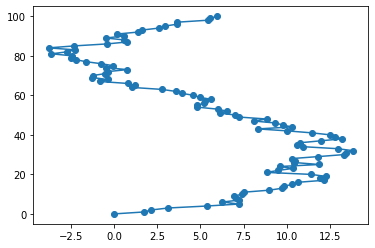

In [4]:
# Generate a random simulation of our latent state dynamics
z = [np.array(0)]
t = [0]
for i in range(100):
    z.append(state_dynamics(z[-1]))
    t.append(i+1)

plt.plot(z,t,'-o')

In [5]:
## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 20
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100
PF_Max = 10 # Maximum firing rate
PF_Width = 25 # Width or fall off in space of Place fields

def mean_rate(z):
    return np.exp(-((z - PF_Centers)/PF_Width)**2) * PF_Max

In the following cell, we changed the observation to be Poisson.

In [6]:
###
### For homework you will change this to Poisson!
###

## For Gaussian model, we need a standard deviation per neuron
Gaussian_PF_Noise_Variance = 10
def observation_gaussian(z, innovation_factor=1):
    # Additive Gaussian noise. Change this to Poisson!
    return mean_rate(z) + innovation_factor*np.random.randn(len(PF_Centers))*np.sqrt(Gaussian_PF_Noise_Variance)


# Randomly generate an observation from neurons
def observation_poisson(z):
    # Additive Poisson noise.
    return np.random.poisson(lam=mean_rate(z)) # lambda is the mean_rate of z

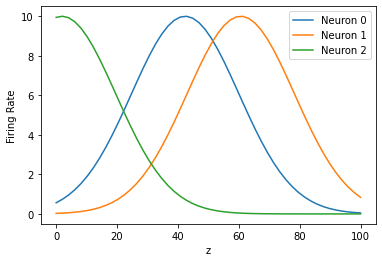

In [7]:
# Plot some example receptive fields
z = np.linspace(0,100)
nn = np.array([mean_rate(z_) for z_ in z])
plt.plot(z,nn[:,0], label='Neuron 0')
plt.plot(z,nn[:,1], label='Neuron 1')
plt.plot(z,nn[:,2], label='Neuron 2')
plt.gca().set_ylabel('Firing Rate')
plt.gca().set_xlabel('z')
plt.legend()
plt.show()

In [8]:
# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)

In [9]:
# Here's the neural activity corresponding to our trajectory

Neural_Activity_gaussian = np.array([observation_gaussian(z) for z in Trajectory])
Neural_Activity_poisson = np.array([observation_poisson(z) for z in Trajectory])

In the following cell, we also chenged the ``p_observation`` to be Poisson.

In [10]:

###
### Homework - Modify this to be Poisson!
### 
    
def p_observation_gaussian(x, z):
    # Quick way of calculating Multivariate normal with uncorrelated dimensions
    # Calculate the product across neurons as exp( sum (log_probabilities) )
    
    # Gaussian
    return np.exp(scipy.stats.norm.logpdf(x, mean_rate(z), np.sqrt(Gaussian_PF_Noise_Variance)).sum())

def p_observation_poisson(x, z):
    # Quick way of calculating Multivariate normal with uncorrelated dimensions
    # Calculate the product across neurons as exp( sum (log_probabilities) )
    
    # Poisson
    return np.exp(scipy.stats.poisson.logpmf(x, mean_rate(z)).sum())

In [11]:
# Run the particle filter
def particle_filter(p_observation, Neural_Activity, N=100): # The number of particles will also be a variable
    Z = []
    I = []
    Z_ = []
    W = []


    # Start by sampling initial distribution, N(0,10)
    # Generate N particles corresponding to time 0
    Z.append(np.random.randn(N)*np.sqrt(10))

    ### In python Z[-1] refers to the last item in a list or vector

    for i in range(101):
        # Calculate a posteriori probability for each particle
        APosterioriProb = np.array([p_observation(Neural_Activity[i,:],z) for z in Z[-1]])
        # Normalize probabilities to get a weight vector
        W.append(APosterioriProb / APosterioriProb.sum())
        # Sample particles using weights - I[] keeps track of the indices chosen
        #  we could do it more efficiently like this:
        #      z_ =  np.random.choice(Z[-1],size=N,replace=True,p=W[-1])
        idx =  np.random.choice(N,size=N,replace=True,p=W[-1])
        I.append(idx)
        z_ = Z[-1][idx]
        Z_.append(z_)
        # Step forward in time by sampling from the dynamics
        Z.append( state_dynamics(z_) )
        
    # For plotting the distribution of particles at a particular time step
    t = 50
    pp = np.array([p_observation(Neural_Activity[t,:],z) for z in Z[t]])
    pp = pp / pp.sum()

    return pp, z, Z, Z_, t, W, N

In [12]:
pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson)

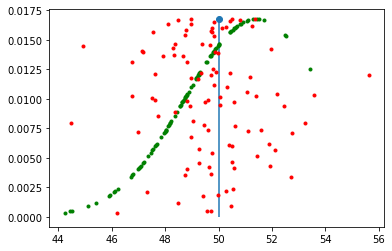

In [13]:
plt.plot(Z[t], pp,'g.')
plt.plot(Z[t+1], pp,'r.')
plt.stem([Trajectory[t]], [np.max(W[t])])
plt.show()

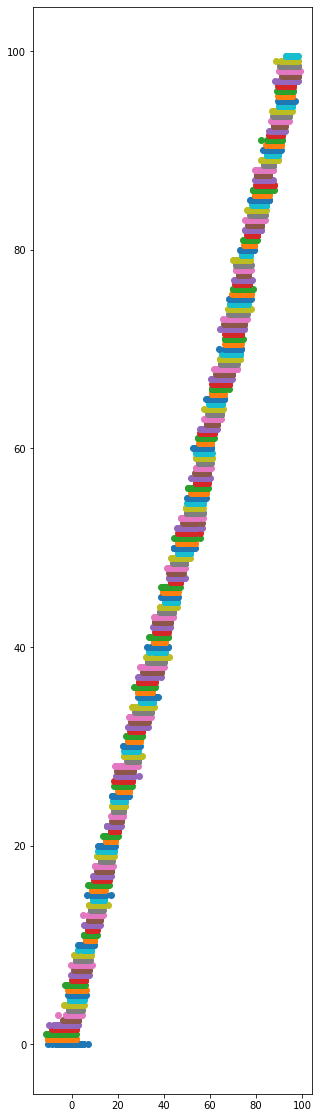

In [14]:
fig, ax = plt.subplots(1,1,figsize=(5,20))
for i in range(100):
    ax.plot(Z[i], i*np.ones(N), 'o')
    ax.plot(Z_[i], i*np.ones(N)+0.5, 'o')

MSE = 4.675923551186773


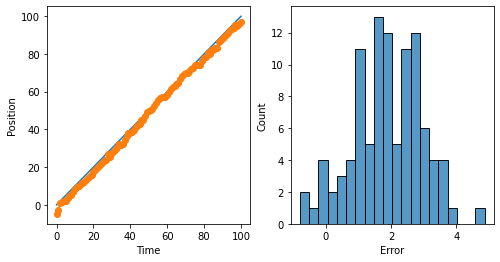

In [15]:
# Calculate estimated trajectory

Z_ = np.array(Z)
W_ = np.array(W)

EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)


# Plot estimated trajectory and error histogram
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].plot(Trajectory)
axs[0].plot(EstimatedTrajectory, '-o')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Position')

Error = (Trajectory - EstimatedTrajectory)

sns.histplot(Error, ax=axs[1], bins=20, kde=False)
axs[1].set_xlabel('Error')
print('MSE = {}'.format(np.mean(Error**2)))

#### Commentary - notice that the error is strongly biased. This is because the animal is moving further 
####   each timestep than would be likely for a N(0,1) random walk. Try changing the "speed" of the animal
####   to 0.5 or 0.1 cm per time step and see if the error is still biased.


We want to generate a cycle that runs, say 3 times for Poisson and 10 times for Gaussian so we can compare MSE values

MSE = 4.434706786845835
MSE = 3.5983500013364735
MSE = 4.2091261420687545


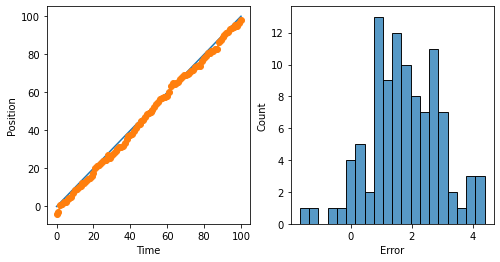

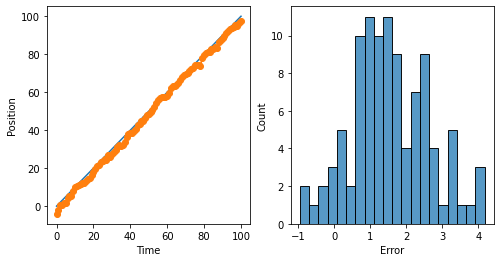

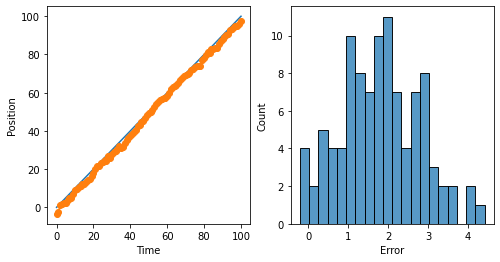

In [16]:
# Poisson cycle
iterations = 3
MSE_poisson = np.zeros(iterations)
# MSE_gaussian = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)


    # Plot estimated trajectory and error histogram
    fig, axs = plt.subplots(1, 2, figsize=(8,4))

    axs[0].plot(Trajectory)
    axs[0].plot(EstimatedTrajectory, '-o')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Position')

    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_poisson[i] = np.mean(Error**2)

MSE = 17.59189347953573
MSE = 16.864275823849916
MSE = 14.528257673323186


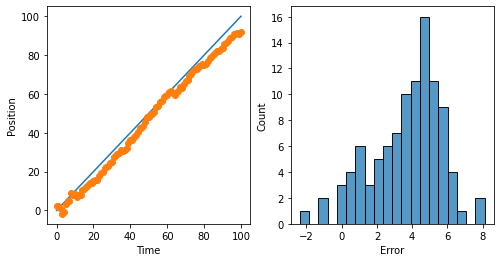

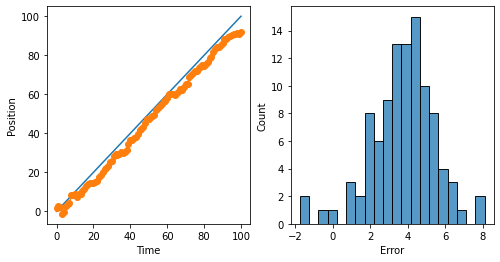

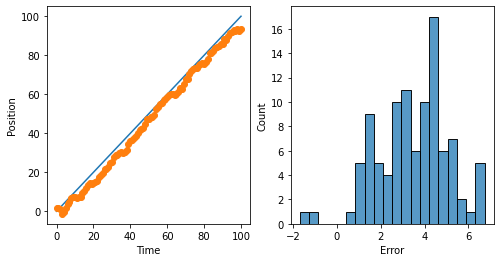

In [17]:
# Gaussian cycle
iterations = 3
MSE_gaussian = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_gaussian, Neural_Activity_gaussian)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)


    # Plot estimated trajectory and error histogram
    fig, axs = plt.subplots(1, 2, figsize=(8,4))

    axs[0].plot(Trajectory)
    axs[0].plot(EstimatedTrajectory, '-o')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Position')

    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_gaussian[i] = np.mean(Error**2)

In [18]:
print("Mean gaussian: ",np.mean(MSE_gaussian))
print("Mean poisson: ",np.mean(MSE_poisson))

Mean gaussian:  16.328142325569612
Mean poisson:  4.080727643417021


Notice how the mean standard error in the gaussian observations are higher compared to the poisson ones. This could be due to the amount of gaussian noise we are adding to the observations. A way in which we could reduce MSW for the gaussian model would be by diminishing the ``Gaussian_PF_Noise_Variance`` because right now it is set to 10, so we could lower it.

b. Experiment with the number of neurons and the maximum firing rates. How does the error change if the number of neurons decreases or increases by a factor of 2? How does the error change if the maximum firing rate decreases or increases by a factor of 2?

c. Experiment with the number of particles. How does the error change if the number of particles used for simulation changes by a factor of 10 (i.e., 10, 100, or 1000)?

d. Experiment with the state dynamics model. What happens to the error if the standard deviation of the “innovation” (the noise term added to the state at each time step) increases or decreases by a factor of 2?

These questions will be adressed in the bar plot at the end.

In [19]:
# Doubling the number of neurons

## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 40 # Originally, there were 20 neurons
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100

z = np.linspace(0,100)
nn = np.array([mean_rate(z_) for z_ in z])

# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)

# Here's the neural activity corresponding to our trajectory
Neural_Activity_gaussian = np.array([observation_gaussian(z) for z in Trajectory])
Neural_Activity_poisson = np.array([observation_poisson(z) for z in Trajectory])

# Poisson cycle
iterations = 3
MSE_poisson_2neurons = np.zeros(iterations)
MSE_gaussian_2neurons = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_poisson_2neurons[i] = np.mean(Error**2)


# Gaussian cycle
for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_gaussian, Neural_Activity_gaussian)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_gaussian_2neurons[i] = np.mean(Error**2)
    
print("Mean gaussian: ",np.mean(MSE_gaussian_2neurons))
print("Mean poisson: ",np.mean(MSE_poisson_2neurons))

MSE = 2.888123619510817
MSE = 2.5170615508189216
MSE = 2.5037482568692235
MSE = 8.076810024431008
MSE = 6.761916436902147
MSE = 6.776817201940834
Mean gaussian:  7.20518122109133
Mean poisson:  2.6363111423996544


In [20]:
# Doubling the firing rate

## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 20 
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100

z = np.linspace(0,100)
nn = np.array([2*mean_rate(z_) for z_ in z]) # Doubling the firing rate

# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)

# Here's the neural activity corresponding to our trajectory
Neural_Activity_gaussian = np.array([observation_gaussian(z) for z in Trajectory])
Neural_Activity_poisson = np.array([observation_poisson(z) for z in Trajectory])

# Poisson cycle
iterations = 3
MSE_poisson_2firing = np.zeros(iterations)
MSE_gaussian_2firing = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_poisson_2firing[i] = np.mean(Error**2)


# Gaussian cycle
for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_gaussian, Neural_Activity_gaussian)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_gaussian_2firing[i] = np.mean(Error**2)
    
print("Mean gaussian: ",np.mean(MSE_gaussian_2firing))
print("Mean poisson: ",np.mean(MSE_poisson_2firing))

MSE = 7.324189542156333
MSE = 8.62798713879019
MSE = 8.571231667468995
MSE = 10.09067462405906
MSE = 9.49605381800342
MSE = 10.822629122816588
Mean gaussian:  10.136452521626355
Mean poisson:  8.174469449471838


In [21]:
# Multiplying the number of particles by a factor of 0.1

## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 20 
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100

z = np.linspace(0,100)
nn = np.array([2*mean_rate(z_) for z_ in z]) # Doubling the firing rate

# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)

# Here's the neural activity corresponding to our trajectory
Neural_Activity_gaussian = np.array([observation_gaussian(z) for z in Trajectory])
Neural_Activity_poisson = np.array([observation_poisson(z) for z in Trajectory])

# Poisson cycle
iterations = 1
MSE_poisson_01factor = np.zeros(iterations)
MSE_gaussian_01factor = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson, 10) #originally 100 particles

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_poisson_01factor[i] = np.mean(Error**2)


# Gaussian cycle
for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_gaussian, Neural_Activity_gaussian, 10) #Originally 100

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_gaussian_01factor[i] = np.mean(Error**2)
    
print("Mean gaussian: ",np.mean(MSE_gaussian_01factor))
print("Mean poisson: ",np.mean(MSE_poisson_01factor))

MSE = 12.608510795564582
MSE = 49.00923756326081
Mean gaussian:  49.00923756326081
Mean poisson:  12.608510795564582


In [22]:
# Multiplying the number of particles by a factor of 10

## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 20 
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100

z = np.linspace(0,100)
nn = np.array([2*mean_rate(z_) for z_ in z]) # Doubling the firing rate

# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)

# Here's the neural activity corresponding to our trajectory
Neural_Activity_gaussian = np.array([observation_gaussian(z) for z in Trajectory])
Neural_Activity_poisson = np.array([observation_poisson(z) for z in Trajectory])

# Poisson cycle
iterations = 1
MSE_poisson_10factor = np.zeros(iterations)
MSE_gaussian_10factor = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson, 1000) #originally 100 particles

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_poisson_10factor[i] = np.mean(Error**2)


# Gaussian cycle
for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_gaussian, Neural_Activity_gaussian, 1000) #Originally 100

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_gaussian_10factor[i] = np.mean(Error**2)
    
print("Mean gaussian: ",np.mean(MSE_gaussian_10factor))
print("Mean poisson: ",np.mean(MSE_poisson_10factor))

MSE = 4.367561905030294
MSE = 12.987820475611416
Mean gaussian:  12.987820475611416
Mean poisson:  4.367561905030294


In [23]:
# Multiplying the number of particles by a factor of 10

## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 20 
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100

z = np.linspace(0,100)
nn = np.array([2*mean_rate(z_) for z_ in z]) # Doubling the firing rate

# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)

# Here's the neural activity corresponding to our trajectory
Neural_Activity_gaussian = np.array([observation_gaussian(z) for z in Trajectory])
Neural_Activity_poisson = np.array([observation_poisson(z) for z in Trajectory])

# Poisson cycle
iterations = 1
MSE_poisson_100factor = np.zeros(iterations)
MSE_gaussian_100factor = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson, 10000) #originally 100 particles

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_poisson_100factor[i] = np.mean(Error**2)


# Gaussian cycle
for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_gaussian, Neural_Activity_gaussian, 10000) #Originally 100

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_gaussian_100factor[i] = np.mean(Error**2)
    
print("Mean gaussian: ",np.mean(MSE_gaussian_100factor))
print("Mean poisson: ",np.mean(MSE_poisson_100factor))

MSE = 5.317021628674957
MSE = 11.009578740278803
Mean gaussian:  11.009578740278803
Mean poisson:  5.317021628674957


In [24]:
# The function observation_gaussian() was modified so it could accept another variable for adding this 2 factor
# It makes no sense to analyze what occurs with the poisson because there will be no change.
# There is no "innovation" term in the poisson distribution.

## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 20
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100

z = np.linspace(0,100)
nn = np.array([mean_rate(z_) for z_ in z])

# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)

# Here's the neural activity corresponding to our trajectory
Neural_Activity_gaussian = np.array([observation_gaussian(z, 2) for z in Trajectory]) # The modification is HERE

# Gaussian cycle
iterations = 3
MSE_gaussian_innovation = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_gaussian, Neural_Activity_gaussian)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)
    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_gaussian_innovation[i] = np.mean(Error**2)
    
print("Mean gaussian: ",np.mean(MSE_gaussian_innovation))

MSE = 73.78643660580592
MSE = 86.51734851794048
MSE = 86.78008588597487
Mean gaussian:  82.36129033657376


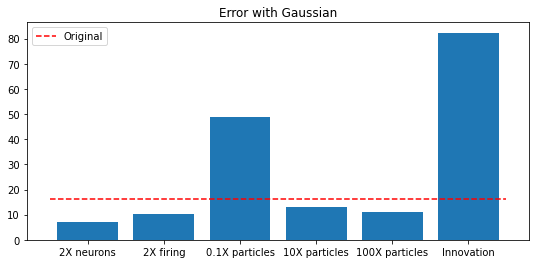

In [25]:
# Barplot graph with help from: https://www.python-graph-gallery.com/barplot/

height_gaussian = [np.mean(MSE_gaussian_2neurons), np.mean(MSE_gaussian_2firing), np.mean(MSE_gaussian_01factor),
                   np.mean(MSE_gaussian_10factor), np.mean(MSE_gaussian_100factor), np.mean(MSE_gaussian_innovation)]
bars = ('2X neurons', '2X firing','0.1X particles', '10X particles', '100X particles', "Innovation")
y_pos = np.arange(len(bars))

fig = plt.figure(figsize=(9,4))
plt.bar(y_pos, height_gaussian) # Create bars
plt.plot([-0.5, len(y_pos)-0.5], [np.mean(MSE_gaussian), np.mean(MSE_gaussian)], linestyle='dashed', color="r", label = "Original")

plt.xticks(y_pos, bars) # Create names on the x-axis
plt.title("Error with Gaussian")
plt.legend()
plt.show()

Note:0.1X particles corresponds to 10 particles, original indicates there are 100 particles, 10X particles refers to 1000 particles and 100X particles indicates there are 10000 particles.

Now, it is easy to interpret what is happening. When we use a gaussian distribution, compared to the original set of parameters, the error is greater when using less particles (10 particles) or when incrementing 2 times the innovation term. We see an error decrease when using two times the number of neurons, two times the firing rate or incrementing the number of particles by factors of 10 or 100.

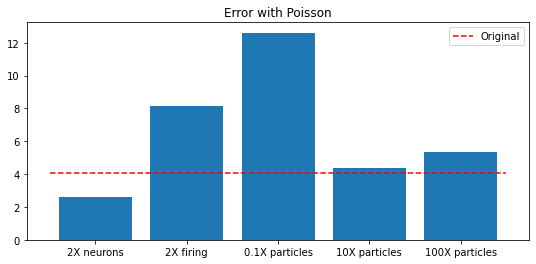

In [26]:
height_poisson = [np.mean(MSE_poisson_2neurons), np.mean(MSE_poisson_2firing), np.mean(MSE_poisson_01factor),
                   np.mean(MSE_poisson_10factor), np.mean(MSE_poisson_100factor)]

bars = ('2X neurons', '2X firing', '0.1X particles', '10X particles', '100X particles')
y_pos = np.arange(len(bars))

fig = plt.figure(figsize=(9,4))
plt.bar(y_pos, height_poisson) # Create bars
plt.plot([-0.5, len(y_pos)-0.5], [np.mean(MSE_poisson), np.mean(MSE_poisson)], linestyle='dashed', color="r", label = "Original")

plt.xticks(y_pos, bars) # Create names on the x-axis
plt.title("Error with Poisson")
plt.legend()
plt.show()

When using the Poisson distribution, as in the Gaussian distribution, we also see an increase in the error when using 10 particles. But note how the error only decreases when using two times the number of neurons. When increasing the firing rate or the number of particles, the error also increases. At least a small interval near the original data would be due to variability.